# Dataset

(<Figure size 640x480 with 1 Axes>, <Axes: >)

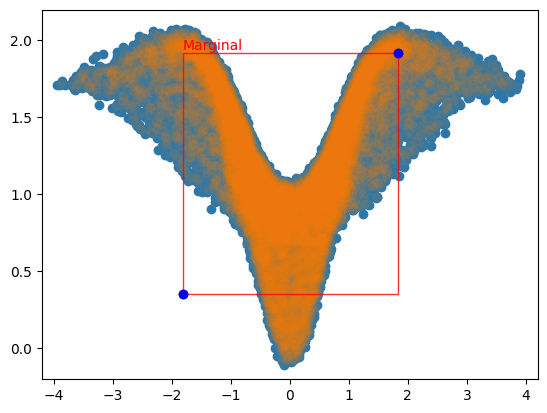

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import math
from tqdm import tqdm
from matplotlib.patches import Rectangle

%load_ext autoreload
%autoreload 2

def synthetic_dataset(n: int, p: int = 1, condition_on_x: torch.Tensor = None):
    """Synthetic dataset from https://arxiv.org/abs/2110.00816, Appendix B.1.

    Args:
        n: sample size
        p: number of features. Defaults to 1 (used in the paper).
        condition_on_x: If None, generates marginal model. If Tesor, expects shape (1, p).
    """
    beta_hat = torch.rand(size=(n, p))
    beta = beta_hat / torch.linalg.norm(beta_hat, ord=1, dim=1, keepdim=True)
    z = 2 * torch.pi * torch.rand(size=(n, p)) - torch.pi
    phi = 2 * torch.pi * torch.rand(size=(n, p))
    r = 2 * 0.1 * torch.rand(size=(n, p)) - 0.1
    if condition_on_x is None:
        x = (3.2 - 0.8) * torch.rand(size=(n, p)) + 0.8
        y_0 = z / (beta * x).sum(dim=1, keepdim=True) + r * torch.cos(phi)
        y_1 = 0.5 * (-torch.cos(z) + 1) + r * torch.sin(phi) + torch.sin(x.mean(dim=1, keepdim=True))
    else:
        x = condition_on_x
        y_0 = z / (beta * x).sum(dim=1, keepdim=True) + r * torch.cos(phi)
        y_1 = 0.5 * (-torch.cos(z) + 1) + r * torch.sin(phi) + torch.sin(x.mean(dim=1, keepdim=True))

    return x, y_0, y_1


def plot_quantiles(y_c, low_q, up_q, ax=None, label="pred", alpha=0.05, gt=True):
    """
    Plots the empirical quantiles and the predicted quantiles.

    Args:
        y_c (torch.Tensor): The data to compute the ground truth quantiles.
        low_q (np.ndarray): The lower quantiles predicted by the model.
        up_q (np.ndarray): The upper quantiles predicted by the model.
        ax (matplotlib.axes.Axes, optional): The axis to plot on. If None, a new figure and axis are created.
        label (str, optional): The label for the predicted quantiles. Defaults to "pred".
    """
    # Compute the empirical quantiles GT
    q_up_gt, q_lo_gt = np.quantile(y_c, 1-alpha, axis=0), np.quantile(y_c, alpha, axis=0)

    y_c = y_c
    y0_low, y1_low = low_q[0], low_q[1]
    y0_up, y1_up = up_q[0], up_q[1]

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    ax.scatter(y_c[:, 0], y_c[:, 1], alpha=0.05)
    # ax.scatter(y_c[:100, 0], y_c[:100, 1], color="green")
    ax.scatter(low_q[0], low_q[1], color="red")
    ax.scatter(up_q[0], up_q[1], color="red")

    # Add rectangles for the predicted quantiles
    pred_rect = Rectangle((y0_low, y1_low), y0_up - y0_low, y1_up - y1_low,
                          edgecolor='red', facecolor='none', alpha=0.8)
    ax.add_patch(pred_rect)
    ax.text(y0_low, y1_up, label, color='red', verticalalignment='bottom')

    # Plot the GT
    ax.scatter(q_lo_gt[0], q_lo_gt[1], color="blue")
    ax.scatter(q_up_gt[0], q_up_gt[1], color="blue")

    # Add rectangles for the ground truth quantiles
    if gt:
        gt_rect = Rectangle((q_lo_gt[0], q_lo_gt[1]), q_up_gt[0] - q_lo_gt[0], q_up_gt[1] - q_lo_gt[1],
                            edgecolor='blue', facecolor='none', alpha=0.8)
        ax.add_patch(gt_rect)
        ax.text(q_lo_gt[0], q_up_gt[1], 'Ground Truth', color='blue', verticalalignment='bottom')

    return fig, ax

# Marginal of Y = (Y_0, Y_1), Fig. 1 (left) of https://arxiv.org/abs/2110.00816
_, y_0, y_1 = synthetic_dataset(n=20000, p=1)
fig, ax = plt.subplots()
offset = 0.2
ax.set_xlim(-4 - offset, 4 + offset)
ax.set_ylim(0 - offset, 2 + offset)
ax.scatter(y_0, y_1)

# Compute marginal quantiles
ALPHA = 0.05  # This is multiplied by the output dimension

y = np.hstack([y_0, y_1])
q_up_gt, q_lo_gt = np.quantile(y, 1-ALPHA, axis=0), np.quantile(y, ALPHA, axis=0)

plot_quantiles(y, q_lo_gt, q_up_gt, ax=ax, label="Marginal", gt=False)

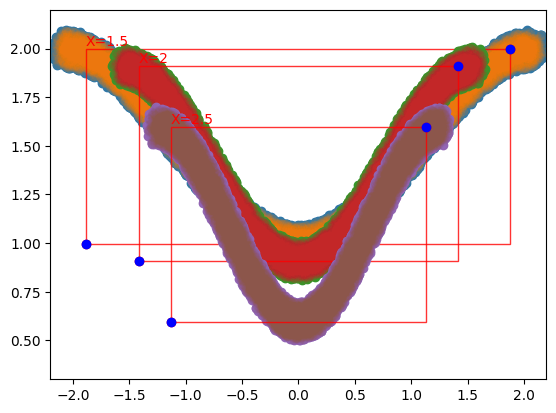

In [3]:
# Condition of Y = (Y_0, Y_1) | X = [1.5, 2, 2.5], Fig. 1 (right) of https://arxiv.org/abs/2110.00816
fig, ax = plt.subplots(ncols=1)
x = [1.5, 2, 2.5]
offset = 0.2
ax.set_xlim(-2 - offset, 2 + offset)
ax.set_ylim(0.5 - offset, 2 + offset)
for j in range(3):
    _, y_0, y_1 = synthetic_dataset(n=20000, condition_on_x=torch.Tensor([x[j]]).reshape(-1, 1))
    ax.scatter(y_0, y_1)
    y_cond_x = np.hstack([y_0, y_1])
    q_up_gt, q_lo_gt = np.quantile(y_cond_x, 1-ALPHA, axis=0), np.quantile(y_cond_x, ALPHA, axis=0)
    plot_quantiles(y_cond_x, q_lo_gt, q_up_gt, ax=ax, label=f"X={x[j]}", gt=False)


In [4]:
# CONFIG================================================================================================================
SAMPLE_SIZE = 20000  # (Table 4)
BATCH_SIZE = 1024  # (Appendix C)
EPOCHS = 500
DEVICE = "cuda:0"
# ======================================================================================================================

# GET DATA==============================================================================================================
x, y_0, y_1 = synthetic_dataset(n=SAMPLE_SIZE, p=1)
y = torch.hstack([y_0, y_1])

# Split dataset intro train, calibration, validation, and test
ntrain, ncal, nval, ntest = (
    int(0.384 * SAMPLE_SIZE),
    int(0.256 * SAMPLE_SIZE),
    int(0.16 * SAMPLE_SIZE),
    int(0.2 * SAMPLE_SIZE),
    )
x_train, y_train = x[:ntrain, :], y[:ntrain, :]
x_cal, y_cal = x[ntrain : ntrain + ncal, :], y[ntrain : ntrain + ncal, :]
x_val, y_val = x[ntrain + ncal : ntrain + ncal + nval, :], y[ntrain + ncal : ntrain + ncal + nval, :]
x_test, y_test = x[ntrain + ncal + nval :, :], y[ntrain + ncal + nval :, :]
print(f"Sanity check: train={x_train.shape[0]}, cal={x_cal.shape[0]}, val={x_val.shape[0]}, test={x_test.shape[0]}")

# Standardize datasets
x_train_mean = x_train.mean(dim=0)
y_train_mean = y_train.mean(dim=0)

x_train_std = x_train.std(dim=0)
y_train_std = y_train.std(dim=0)

x_train = (x_train - x_train_mean) / x_train_std
y_train = (y_train - y_train_mean) / y_train_std

x_cal = (x_cal - x_train_mean) / x_train_std
y_cal = (y_cal - y_train_mean) / y_train_std

x_val = (x_val - x_train_mean) / x_train_std
y_val = (y_val - y_train_mean) / y_train_std

x_test = (x_test - x_train_mean) / x_train_std
y_test = (y_test - y_train_mean) / y_train_std

# Wrap tensors into Dataset and DataLoader
train_ds = TensorDataset(x_train, y_train)
cal_ds = TensorDataset(x_cal, y_cal)
val_ds = TensorDataset(x_val, y_val)
test_ds = TensorDataset(x_test, y_test)

train_dl = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE)
cal_dl = DataLoader(cal_ds, shuffle=False, batch_size=len(cal_ds))
val_dl = DataLoader(val_ds, shuffle=False, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE)

Sanity check: train=7680, cal=5120, val=3200, test=4000


# Naive Multivariate Conformalized Quantile Regression (Use This!)

In [6]:
def pinball_loss(input: torch.Tensor, target: torch.Tensor, gamma: float):
    """Pinball loss of https://arxiv.org/pdf/2107.07511 (page 8) to learn (gamma/2)-quantiles.

    Args:
        input: Model output.
        target: Ground truth.
        gamma: Quantile to regress.

    """
    errors = target - input
    loss = torch.maximum(errors * gamma, -errors * (1 - gamma)).mean()
    return loss


def make_mlp(
    input_dim: int = 1,
    output_dim: int = 2,
    layer_size: int = 32,
    n_hidden: int = 2,
    activation: torch.nn.Module = torch.nn.ELU,
):
    layers = [Linear(input_dim, layer_size), activation(), BatchNorm1d(layer_size)]
    for _ in range(n_hidden - 1):
        layers += [Linear(layer_size, layer_size), activation(), BatchNorm1d(layer_size)]
    layers += [Linear(layer_size, output_dim), activation()]
    return Sequential(*layers)


# GET MODEL=============================================================================================================
# TODO: Implement multivariate QR as in the paper
lower_quantile_estimator = make_mlp(output_dim=2, layer_size=64, n_hidden=3).to(DEVICE)
upper_quantile_estimator = make_mlp(output_dim=2, layer_size=64, n_hidden=3).to(DEVICE)

# TRAIN MODEL===========================================================================================================
# TODO: Change to a single model
opt_lo = torch.optim.Adam(lower_quantile_estimator.parameters())
opt_up = torch.optim.Adam(upper_quantile_estimator.parameters())


def train(
    lo_q_est: torch.nn.Module,
    up_q_est: torch.nn.Module,
    train_dl: DataLoader,
    opt_lo: torch.optim.Optimizer,
    opt_up: torch.optim.Optimizer,
):
    lo_q_est.train()
    up_q_est.train()
    for batch, (x, y) in enumerate(train_dl):
        x, y = x.to(DEVICE), y.to(DEVICE)
        q_lo, q_up = lo_q_est(x), up_q_est(x)

        loss_lo = pinball_loss(input=q_lo, target=y, gamma=ALPHA / 2)
        loss_up = pinball_loss(input=q_up, target=y, gamma=1 - ALPHA / 2)

        loss_lo.backward()
        loss_up.backward()

        opt_lo.step()
        opt_up.step()

        opt_lo.zero_grad()
        opt_up.zero_grad()


for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    # print(f"EPOCH: {epoch}")
    train(
        lo_q_est=lower_quantile_estimator,
        up_q_est=upper_quantile_estimator,
        train_dl=train_dl,
        opt_lo=opt_lo,
        opt_up=opt_up,
    )

    # if epoch % 25 == 0:
    # validate()

# CALIBRATION===========================================================================================================


def calibrate(
    lo_q_est: torch.nn.Module,
    up_q_est: torch.nn.Module,
    cal_ds: TensorDataset,
):
    lo_q_est.eval()
    up_q_est.eval()
    n_cal = len(cal_ds)
    adjusted_alpha = math.ceil((n_cal + 1) * (1 - ALPHA)) / n_cal

    with torch.no_grad():
        x, y = cal_ds.tensors
        x, y = x.to(DEVICE), y.to(DEVICE)

        q_lo, q_up = lo_q_est(x), up_q_est(x)

        nonconformity_scores = torch.maximum(q_lo - y, y - q_up).max(dim=1, keepdim=True)[0]

        q_hat = torch.quantile(nonconformity_scores, adjusted_alpha, interpolation="higher").item()

        return q_hat


q_hat = calibrate(lo_q_est=lower_quantile_estimator, up_q_est=upper_quantile_estimator, cal_ds=cal_ds)
print(f"Empirical Quantile Estimated with CP: {q_hat}")


# EVALUATION============================================================================================================
def test(lo_q_est: torch.nn.Module, up_q_est: torch.nn.Module, test_dl: DataLoader, q_hat: float):
    coverage = 0
    set_size = 0
    lo_q_est.eval()
    up_q_est.eval()
    with torch.no_grad():
        for batch, (x, y) in enumerate(test_dl):
            x, y = x.to(DEVICE), y.to(DEVICE)

            # Conformalize quantile estimates
            q_lo, q_up = lo_q_est(x) - q_hat, up_q_est(x) + q_hat

            coverage += ((q_lo <= y).all(dim=1, keepdim=True) & (y <= q_up).all(dim=1, keepdim=True)).type_as(y).mean()
            set_size += (q_up - q_lo).abs().prod(dim=1, keepdim=True).mean()
    coverage /= len(test_dl)
    set_size /= len(test_dl)

    return coverage, set_size


coverage, set_size = test(
    lo_q_est=lower_quantile_estimator, up_q_est=upper_quantile_estimator, test_dl=test_dl, q_hat=q_hat
)
print(f"Avg. empirical coverage: {coverage.item() * 100:.2f}% Avg. set size: {set_size.item():.2f}")


Epochs: 100%|██████████| 500/500 [00:42<00:00, 11.65it/s]


Empirical Quantile Estimated with CP: 1.073915958404541
Avg. empirical coverage: 95.22% Avg. set size: 19.25


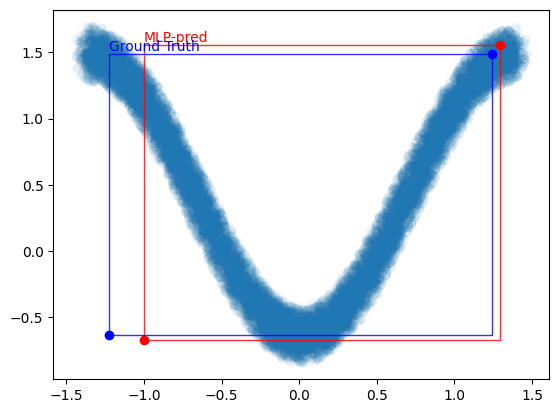

In [9]:
# Quantile Regression, Fig 2 of https://arxiv.org/abs/2110.00816

x, y_0, y_1 = synthetic_dataset(n=SAMPLE_SIZE, p=1, condition_on_x=torch.Tensor([2.0]).reshape(1, 1))
y = torch.hstack([y_0, y_1])
y_c = (y - y_train_mean) / y_train_std
x_c = (x - x_train_mean) / x_train_std
low_q = torch.squeeze(lower_quantile_estimator(x_c.to(DEVICE))).detach().cpu().numpy()
up_q = torch.squeeze(upper_quantile_estimator(x_c.to(DEVICE))).detach().cpu().numpy()


# Compute the empirical quantiles GT.
q_up_gt, q_lo_gt = np.quantile(y_c, ALPHA, axis=0), np.quantile(y_c, ALPHA, axis=0)

y_c = y_c.cpu().numpy()

fig, ax = plot_quantiles(y_c, low_q, up_q, label="MLP-pred", alpha=ALPHA)


# NCP training

In [8]:
import numpy as np
from symm_rep_learn.nn.layers import MLP
from symm_rep_learn.models.ncp import NCP

ncp = NCP(
    embedding_x=MLP(input_shape=1, output_shape=32, layer_size=64, n_hidden=3),
    embedding_y=MLP(input_shape=2, output_shape=32, layer_size=64, n_hidden=3),
    embedding_dim=32,
    gamma=1).to(DEVICE)

lr = 1e-3
ncp_optimizer = torch.optim.Adam(ncp.parameters(), lr=lr)

CHECK_VAL_EVERY_N_EPOCHS = int(EPOCHS / 10)
# Initialize the progress bar
pbar = tqdm(range(EPOCHS), desc="Epochs")

relevant_metrics = ['tr(Cx)', 'tr(Cy)']
val_loss = np.infty
for epoch in pbar:
    ncp.train()
    for x, y in train_dl:
        x, y = x.to(DEVICE), y.to(DEVICE)
        ncp_optimizer.zero_grad()
        fx, hy = ncp(x, y)
        loss, metrics = ncp.loss(fx, hy)

        loss.backward()
        ncp_optimizer.step()

        # Update the progress bar with the loss
        pbar.set_postfix(loss=loss.item(), val_loss=val_loss, **{k: v for k, v in metrics.items() if k in relevant_metrics})
    if epoch % CHECK_VAL_EVERY_N_EPOCHS == 0:
        ncp.eval()
        with torch.no_grad():
            val_loss = 0

            for x, y in val_dl:
                x, y = x.to(DEVICE), y.to(DEVICE)
                fx, hy = ncp(x, y)
                loss, metrics = ncp.loss(fx, hy)
                val_loss += loss.item()
                pbar.set_postfix(val_loss=loss)
            val_loss /= len(val_dl)
        # print('', end='\n')

Epochs: 100%|██████████| 500/500 [01:16<00:00,  6.55it/s, loss=-0.142, tr(Cx)=0.0559, tr(Cy)=0.293, val_loss=-0.11]     


## Use NCP for quantile regression

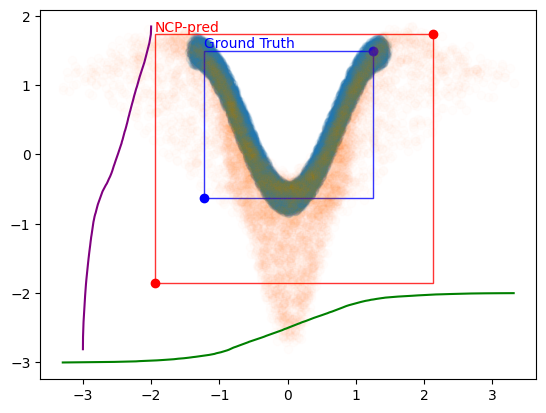

In [20]:
from sklearn.isotonic import IsotonicRegression
from symm_rep_learn.inference.ncp import ncp_regression

def smooth_cdf(values, cdf): # Moved smooth_cdf here from NCP/utils.py
    scdf = IsotonicRegression(y_min=0., y_max=cdf.max()).fit_transform(values, cdf)
    if scdf.max() <= 0:
        return np.zeros(values.shape)
    scdf = scdf/scdf.max()
    return scdf

def find_best_quantile(x, cdf, alpha):
    x = x.flatten()
    t0 = 0
    t1 = 1
    best_t0 = 0
    best_t1 = -1
    best_size = np.inf
    while t0 < len(cdf):
        # stop if left border reaches right end of discretisation
        if cdf[t1] - cdf[t0] >= 1-alpha:
            # if x[t0], x[t1] is a confidence interval at level alpha, compute length and compare to best
            size = x[t1] - x[t0]
            if size < best_size:
                best_t0 = t0
                best_t1 = t1
                best_size = size
            # moving t1 to the right will only increase the size of the interval, so we can safely move t0 to the right
            t0 += 1
        elif t1 == len(cdf)-1:
            # if x[t0], x[t1] is not a confidence interval with confidence at least level alpha,
            #and t1 is already at the right limit of the discretisation, then there remains no more pertinent intervals
            break
        else:
            # if moving x[t0] to the right reduces the level, we need to increase t1
            t1 += 1
    return x[best_t0], x[best_t1]

spread = torch.max(y_train) - torch.min(y_train)
p1, p99 = torch.min(y_train, dim=0).values, torch.max(y_train, dim=0).values
y_disct_steps = 500

support_obs = np.linspace(p1.numpy(), p99.numpy(), y_disct_steps) # (discretization_points, y_dim)
cdf_obs_ind = (y_train.detach().cpu().numpy()[:, None, :] <= support_obs[None, :, :] ).astype(int)   # (n_samples, discretization_points, y_dim)
# Estimate the CDF
estimated_CDF = cdf_obs_ind.mean(axis=0)       # (discretization_points,) -> F(y') -> P(Y <= y')

n_obs_dims = y_train.shape[1]
quantiles = []
ccdf = []
for dim in range(n_obs_dims):
    # Compute the conditional indicator sets per each y' in the support given X=x.
    ccdf_obs_ind_pred = ncp_regression(
        model=ncp,
        x_cond=x_c,
        y_train=y_train,
        zy_train=torch.tensor(cdf_obs_ind, dtype=torch.float32)[..., dim],
        lstsq=True).cpu().numpy()
    ccdf_obs_ind_smooth = smooth_cdf(support_obs[...,dim], np.squeeze(ccdf_obs_ind_pred))
    dim_quantiles = find_best_quantile(support_obs[...,dim], ccdf_obs_ind_smooth, ALPHA)
    quantiles.append(dim_quantiles)
    ccdf.append(ccdf_obs_ind_smooth)
quantiles

q_low = quantiles[0][0], quantiles[1][0]
q_up = quantiles[0][1], quantiles[1][1]

fig, ax = plot_quantiles(y_c, q_low, q_up, label="NCP-pred", alpha=ALPHA)
# PLot the marginal CDF of each dimension
ax.scatter(y_train[:, 0], y_train[:, 1], alpha=0.01)
ax.plot(support_obs[:, 0], ccdf[0] - 3, label='CDF Y_0', color='green')
ax.plot(ccdf[1] - 3, support_obs[:, 1], label='CDF Y_1', color='purple')

# Naive Univariate Conformalized Quantile Regression

In [7]:
# Quantile Regression, Fig 2 of https://arxiv.org/abs/2110.00816
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import math


def pinball_loss(input: torch.Tensor, target: torch.Tensor, gamma: float):
    """Pinball loss of https://arxiv.org/pdf/2107.07511 (page 8) to learn (gamma/2)-quantiles.

    Args:
        input: Model output.
        target: Ground truth.
        gamma: Quantile to regress.

    """
    errors = target - input
    loss = torch.maximum(errors * gamma, -errors * (1 - gamma)).mean()
    return loss


def make_mlp(
    input_dim: int = 1,
    output_dim: int = 2,
    layer_size: int = 32,
    n_hidden: int = 2,
    activation: torch.nn.Module = torch.nn.ELU,
):
    layers = [Linear(input_dim, layer_size), activation(), BatchNorm1d(layer_size)]
    for _ in range(n_hidden - 1):
        layers += [Linear(layer_size, layer_size), activation(), BatchNorm1d(layer_size)]
    layers += [Linear(layer_size, output_dim), activation()]
    return Sequential(*layers)


# CONFIG================================================================================================================
SAMPLE_SIZE = 20000  # (Table 4)
BATCH_SIZE = 256  # (Appendix C)
EPOCHS = 1000
DEVICE = "cuda:0"
ALPHA = 0.05

# GET DATA==============================================================================================================
x, y_0, y_1 = synthetic_dataset(n=SAMPLE_SIZE, p=1)
# y = torch.hstack([y_0, y_1])
y = y_0  # TODO: HOW TO DO THIS??

# Split dataset intro train, calibration, validation, and test
ntrain, ncal, nval, ntest = (
    int(0.384 * SAMPLE_SIZE),
    int(0.256 * SAMPLE_SIZE),
    int(0.16 * SAMPLE_SIZE),
    int(0.2 * SAMPLE_SIZE),
)
x_train, y_train = x[:ntrain, :], y[:ntrain, :]
x_cal, y_cal = x[ntrain : ntrain + ncal, :], y[ntrain : ntrain + ncal, :]
x_val, y_val = x[ntrain + ncal : ntrain + ncal + nval, :], y[ntrain + ncal : ntrain + ncal + nval, :]
x_test, y_test = x[ntrain + ncal + nval :, :], y[ntrain + ncal + nval :, :]
print(f"Sanity check: train={x_train.shape[0]}, cal={x_cal.shape[0]}, val={x_val.shape[0]}, test={x_test.shape[0]}")

# Standardize datasets
x_train_mean = x_train.mean(dim=0)
y_train_mean = y_train.mean(dim=0)

x_train_std = x_train.std(dim=0)
y_train_std = y_train.std(dim=0)

x_train = (x_train - x_train_mean) / x_train_std
y_train = (y_train - y_train_mean) / y_train_std

x_cal = (x_cal - x_train_mean) / x_train_std
y_cal = (y_cal - y_train_mean) / y_train_std

x_val = (x_val - x_train_mean) / x_train_std
y_val = (y_val - y_train_mean) / y_train_std

x_test = (x_test - x_train_mean) / x_train_std
y_test = (y_test - y_train_mean) / y_train_std

# Wrap tensors into Dataset and DataLoader
train_ds = TensorDataset(x_train, y_train)
cal_ds = TensorDataset(x_cal, y_cal)
val_ds = TensorDataset(x_val, y_val)
test_ds = TensorDataset(x_test, y_test)

train_dl = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE)
cal_dl = DataLoader(cal_ds, shuffle=False, batch_size=len(cal_ds))
val_dl = DataLoader(val_ds, shuffle=False, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE)

# GET MODEL=============================================================================================================
# TODO: Implement multivariate QR as in the paper
lower_quantile_estimator = make_mlp(output_dim=1, layer_size=64, n_hidden=3).to(DEVICE)
upper_quantile_estimator = make_mlp(output_dim=1, layer_size=64, n_hidden=3).to(DEVICE)

# TRAIN MODEL===========================================================================================================
# TODO: Change to a single model
opt_lo = torch.optim.Adam(lower_quantile_estimator.parameters())
opt_up = torch.optim.Adam(upper_quantile_estimator.parameters())


def train(
    lo_q_est: torch.nn.Module,
    up_q_est: torch.nn.Module,
    train_dl: DataLoader,
    opt_lo: torch.optim.Optimizer,
    opt_up: torch.optim.Optimizer,
):
    lo_q_est.train()
    up_q_est.train()
    for batch, (x, y) in enumerate(train_dl):
        x, y = x.to(DEVICE), y.to(DEVICE)
        q_lo, q_up = lo_q_est(x), up_q_est(x)

        loss_lo = pinball_loss(input=q_lo, target=y, gamma=ALPHA / 2)
        loss_up = pinball_loss(input=q_up, target=y, gamma=1 - ALPHA / 2)

        loss_lo.backward()
        loss_up.backward()

        opt_lo.step()
        opt_up.step()

        opt_lo.zero_grad()
        opt_up.zero_grad()


for epoch in range(EPOCHS):
    print(f"EPOCH: {epoch}")
    train(
        lo_q_est=lower_quantile_estimator,
        up_q_est=upper_quantile_estimator,
        train_dl=train_dl,
        opt_lo=opt_lo,
        opt_up=opt_up,
    )

    # if epoch % 25 == 0:
    # validate()

# CALIBRATION===========================================================================================================


def calibrate(
    lo_q_est: torch.nn.Module,
    up_q_est: torch.nn.Module,
    cal_ds: TensorDataset,
):
    lo_q_est.eval()
    up_q_est.eval()
    n_cal = len(cal_ds)
    adjusted_alpha = math.ceil((n_cal + 1) * (1 - ALPHA)) / n_cal

    with torch.no_grad():
        x, y = cal_ds.tensors
        x, y = x.to(DEVICE), y.to(DEVICE)

        q_lo, q_up = lo_q_est(x), up_q_est(x)

        nonconformity_scores = torch.maximum(q_lo - y, y - q_up)

        q_hat = torch.quantile(nonconformity_scores, adjusted_alpha, interpolation="higher").item()

        return q_hat


q_hat = calibrate(lo_q_est=lower_quantile_estimator, up_q_est=upper_quantile_estimator, cal_ds=cal_ds)
print(f"Empirical Quantile Estimated with CP: {q_hat}")


# EVALUATION============================================================================================================


def test(lo_q_est: torch.nn.Module, up_q_est: torch.nn.Module, test_dl: DataLoader, q_hat: float):
    coverage = 0
    interval_size = 0
    lo_q_est.eval()
    up_q_est.eval()
    with torch.no_grad():
        for batch, (x, y) in enumerate(test_dl):
            x, y = x.to(DEVICE), y.to(DEVICE)

            # Conformalize quantile estimates
            q_lo, q_up = lo_q_est(x) - q_hat, up_q_est(x) + q_hat

            coverage += ((q_lo <= y) & (y <= q_up)).type_as(y).mean()
            interval_size += (q_up - q_lo).abs().mean()
    coverage /= len(test_dl)
    interval_size /= len(test_dl)

    return coverage, interval_size


coverage, interval_size = test(
    lo_q_est=lower_quantile_estimator, up_q_est=upper_quantile_estimator, test_dl=test_dl, q_hat=q_hat
)
print(f"Avg. empirical coverage: {coverage.item() * 100:.2f}% Avg. set size: {interval_size.item():.2f}")


Sanity check: train=7680, cal=5120, val=3200, test=4000
EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4
EPOCH: 5
EPOCH: 6
EPOCH: 7
EPOCH: 8
EPOCH: 9
EPOCH: 10
EPOCH: 11
EPOCH: 12
EPOCH: 13
EPOCH: 14
EPOCH: 15
EPOCH: 16
EPOCH: 17
EPOCH: 18
EPOCH: 19
EPOCH: 20
EPOCH: 21
EPOCH: 22
EPOCH: 23
EPOCH: 24
EPOCH: 25
EPOCH: 26
EPOCH: 27
EPOCH: 28
EPOCH: 29
EPOCH: 30
EPOCH: 31
EPOCH: 32
EPOCH: 33
EPOCH: 34
EPOCH: 35
EPOCH: 36
EPOCH: 37
EPOCH: 38
EPOCH: 39
EPOCH: 40
EPOCH: 41
EPOCH: 42
EPOCH: 43
EPOCH: 44
EPOCH: 45
EPOCH: 46
EPOCH: 47
EPOCH: 48
EPOCH: 49
EPOCH: 50
EPOCH: 51
EPOCH: 52
EPOCH: 53
EPOCH: 54
EPOCH: 55
EPOCH: 56
EPOCH: 57
EPOCH: 58
EPOCH: 59
EPOCH: 60
EPOCH: 61
EPOCH: 62
EPOCH: 63
EPOCH: 64
EPOCH: 65
EPOCH: 66
EPOCH: 67
EPOCH: 68
EPOCH: 69
EPOCH: 70
EPOCH: 71
EPOCH: 72
EPOCH: 73
EPOCH: 74
EPOCH: 75
EPOCH: 76
EPOCH: 77
EPOCH: 78
EPOCH: 79
EPOCH: 80
EPOCH: 81
EPOCH: 82
EPOCH: 83
EPOCH: 84
EPOCH: 85
EPOCH: 86
EPOCH: 87
EPOCH: 88
EPOCH: 89
EPOCH: 90
EPOCH: 91
EPOCH: 92
EPOCH: 93
EPOCH: 94
EPOC

KeyboardInterrupt: 